In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import json, requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from scripts.model_config import ModelConfig
from scripts.pixel_score import PixelScore
from scripts.video import VideoCallback
import numpy as np
import os
import pandas as pd

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Device set to CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Device set to MPS.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Device set to CPU.")

Neither CUDA nor MPS is available. Device set to CPU.


In [6]:
os.makedirs('results/ablation', exist_ok=True)

In [7]:
# Load labels from ImageNet
labels_path = "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"
json_data = requests.get(labels_path)
idx_to_labels = json.load(BytesIO(json_data.content))

# Load and transform inputs images
normalization_mu=[0.485, 0.456, 0.406]
normalization_sigma=[0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mu, normalization_sigma)
])

imgs_url=["https://i.imgur.com/WuG5RVB.jpg", "https://i.imgur.com/Si6ZHrQ.jpeg", "https://i.imgur.com/z011H.jpeg", "https://i.imgur.com/AfyUEtU.jpg"]
imgs_url_image_net = ["https://i.imgur.com/Pcavy1G.jpg", "https://i.imgur.com/fDxRH0b.jpg", "https://i.imgur.com/mQRjExW.jpg", "https://i.imgur.com/Ntw7dL0.jpg", "https://i.imgur.com/u54Nckm.jpg", "https://i.imgur.com/b01NsQ9.jpg", "https://i.imgur.com/bJNJlVN.jpg", "https://i.imgur.com/S8I25xy.jpg", "https://i.imgur.com/k54XU8g.jpg", "https://i.imgur.com/rDawyls.jpg", "https://i.imgur.com/7vY3Nph.jpg", "https://i.imgur.com/BcGstKL.jpg", "https://i.imgur.com/MxeeyFj.jpg"]
imgs_url.extend(imgs_url_image_net)
print(f"{len(imgs_url)} images loaded")

inputs = []
for img_url in imgs_url:
    response = requests.get(img_url, headers = {'User-agent': ''})
    img = Image.open(BytesIO(response.content))
    input = transform(img)
    inputs.append(input)

inputs = torch.stack(inputs, dim=0)
inputs.shape

17 images loaded


torch.Size([17, 3, 224, 224])

In [8]:
def denormalize(input, mean, std):
    input = input.clone()
    for t, m, s in zip(input, mean, std):
        t.mul_(s).add_(m)
    return input

In [9]:
denormalized_inputs = []
for input in inputs:
    denormalized_input = denormalize(input, normalization_mu, normalization_sigma)
    denormalized_inputs.append(denormalized_input)
denormalized_inputs = torch.stack(denormalized_inputs, dim=0)
denormalized_inputs = denormalized_inputs.permute(0,2,3,1).cpu()
denormalized_inputs.shape

torch.Size([17, 224, 224, 3])

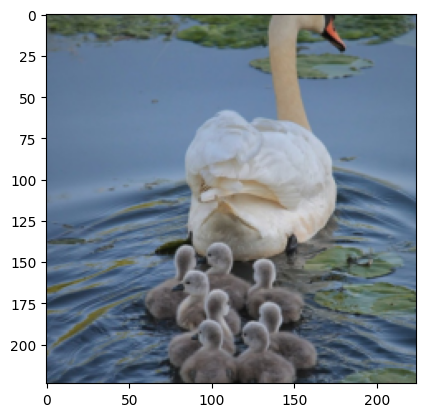

In [10]:
plt.imshow(denormalized_inputs[0])
plt.show()

# run

In [11]:
torch.set_grad_enabled(False)

In [12]:
#@title CONFIG
#{run: "auto"}

model_name = 'resnet18' #@param ["vgg16", "resnet18", "efficientnet_v2_s", "convnext_tiny"]
attribution_name = 'layer4' # @param ["features", "layer4"] {allow-input: true}
layer_number = 1 # @param {type:"slider", min:0, max:128, step:1}
n_masks = 2048 # @param {type:"integer"}
initial_mask_shape = 4 # @param {type:"integer"}
isotropic_sigma = 10 # @param {type:"number"}
patience=64 # @param {type:"integer"}
d_epsilon=1e-3 # @param {type:"slider", min:0, max:0.1, step:0.001}
threshold=0.3 # @param {type:"number"}
strides = '(3, 50, 50)' # @param {type:"string"}
sliding_window_shapes = '(3,60, 60)' # @param {type:"string"}
ps_mode = 'dilation' # @param ["erosion", "dilation"]
force_rise = False # @param {type:"boolean"}
ps_threshold=0.5


run_mode = f'run_{ps_mode}'
attr_str = f'{attribution_name}[{layer_number}]'
initial_mask_shape = (initial_mask_shape,initial_mask_shape)

In [13]:
import ast
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return
strides = parse_tuple(strides)
sliding_window_shapes = parse_tuple(sliding_window_shapes)
strides, sliding_window_shapes

((3, 50, 50), (3, 60, 60))

In [14]:
raw_model = getattr(models, model_name)(weights='DEFAULT') #models.vgg16(weights='DEFAULT')
model = ModelConfig(raw_model, inputs)
model.set_model_config(device=device)

In [15]:
model_preds = model.run_forward_pass(idx_to_labels,verbose=False)
model_preds

[{'id': 100, 'predicted_label': 'black_swan', 'score': 0.4683021903038025},
 {'id': 291, 'predicted_label': 'lion', 'score': 0.9998741149902344},
 {'id': 226, 'predicted_label': 'briard', 'score': 0.698599636554718},
 {'id': 143, 'predicted_label': 'oystercatcher', 'score': 0.9179422855377197},
 {'id': 230,
  'predicted_label': 'Shetland_sheepdog',
  'score': 0.9109706878662109},
 {'id': 101, 'predicted_label': 'tusker', 'score': 0.8604390025138855},
 {'id': 80, 'predicted_label': 'black_grouse', 'score': 0.9912539124488831},
 {'id': 275,
  'predicted_label': 'African_hunting_dog',
  'score': 0.9988518953323364},
 {'id': 283, 'predicted_label': 'Persian_cat', 'score': 0.9970255494117737},
 {'id': 274, 'predicted_label': 'dhole', 'score': 0.914912223815918},
 {'id': 243, 'predicted_label': 'bull_mastiff', 'score': 0.37958282232284546},
 {'id': 176, 'predicted_label': 'Saluki', 'score': 0.4868932068347931},
 {'id': 195, 'predicted_label': 'Boston_bull', 'score': 0.7722286581993103},
 {'i

In [16]:
id_values = [item['id'] for item in model_preds]
pred_label_idx = torch.tensor(id_values, device=inputs.device)
pred_label_idx.shape,pred_label_idx

(torch.Size([17]),
 tensor([100, 291, 226, 143, 230, 101,  80, 275, 283, 274, 243, 176, 195, 130,
          37,  16, 330]))

In [17]:
upsample_shape = (inputs.shape[2], inputs.shape[3])

## activations

In [18]:
activations = model.get_activations(attr_str, pool=True) #"features[30]"

activations = ModelConfig.heatmap_upsample(activations, upsample_shape)
activations = ModelConfig.heatmap_normalize(activations)
activations.shape, activations.min(), activations.max()

(torch.Size([17, 224, 224]), tensor(0.), tensor(1.))

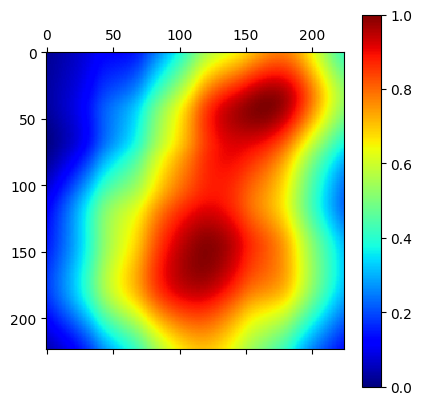

In [19]:
plt.matshow(activations[0].cpu().detach().numpy(), cmap='jet')
plt.colorbar()

## gradcam

In [20]:
torch.set_grad_enabled(True) #for gradcam

In [21]:
heatmap_gc = model.get_grad_cam(attr_str) #"features[30]"

heatmap_gc = ModelConfig.heatmap_upsample(heatmap_gc, upsample_shape)
heatmap_gc = ModelConfig.heatmap_normalize(heatmap_gc)
heatmap_gc.shape, heatmap_gc.min(), heatmap_gc.max()

(torch.Size([17, 224, 224]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

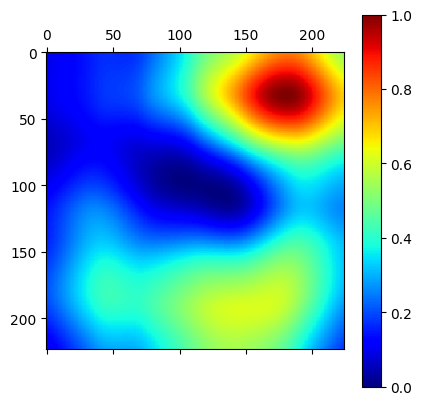

In [22]:
plt.matshow(heatmap_gc[0].cpu().detach().numpy(), cmap='jet')
plt.colorbar()

## occlusion

In [23]:
heatmap_occ = model.get_occlusion(strides,sliding_window_shapes)

heatmap_occ = ModelConfig.heatmap_normalize(heatmap_occ)
heatmap_occ.shape, heatmap_occ.min(), heatmap_occ.max()

Occlusion attribution:   0%|          | 0/26 [00:00<?, ?it/s]

(torch.Size([17, 3, 224, 224]), tensor(0.), tensor(1.))

In [24]:
heatmap_occ = heatmap_occ[:,0,:]
heatmap_occ.shape

torch.Size([17, 224, 224])

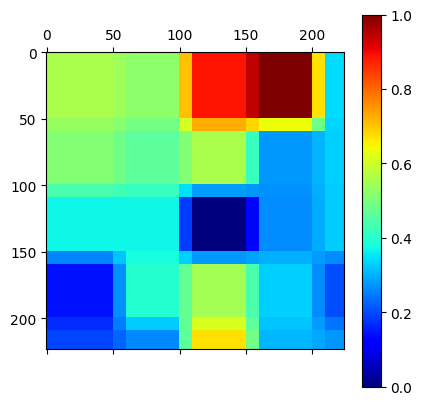

In [25]:
plt.matshow(heatmap_occ[0].cpu().detach().numpy(), cmap='jet')
plt.colorbar()

## rise

In [26]:
torch.set_grad_enabled(False)

In [27]:
try:
    if force_rise:
        raise Exception("Forcing RISE execution.")
    heatmap_rise = torch.load(f'results/ablation/heatmap_rise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt', map_location=device)
except:
    heatmap_rise = model.get_rise(n_masks, initial_mask_shape)
    torch.save(heatmap_rise , f'results/ablation/heatmap_rise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt')

C:\Users\Cacho\AppData\Local\Temp\ipykernel_16260\2496859951.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  heatmap_rise = torch.load(f'results/ablation/heatmap_rise_le

In [28]:
heatmap_rise = ModelConfig.heatmap_normalize(heatmap_rise)
heatmap_rise.shape, heatmap_rise.min(), heatmap_rise.max()

(torch.Size([17, 224, 224]), tensor(0.), tensor(1.))

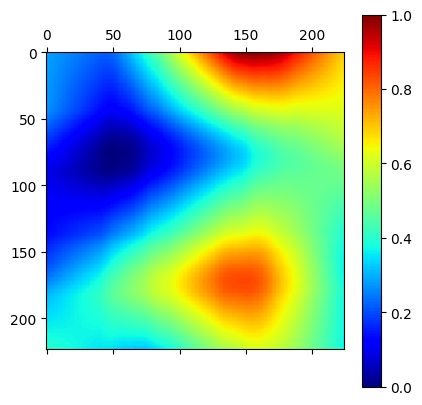

In [29]:
plt.matshow(heatmap_rise[0].cpu().detach().numpy(), cmap='jet')
plt.colorbar()

## cbrise

In [30]:
try:
    if force_rise:
        raise Exception("Forcing RISE execution.")
    heatmap_cbrise = torch.load(f'results/ablation/heatmap_cbrise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt', map_location=device)
    metrics_cbrise = torch.load(f'results/ablation/metrics_cbrise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt', map_location=device)
except:
    heatmap_cbrise, metrics_cbrise = model.get_cbrise(n_masks, 
                                                initial_mask_shape, 
                                                blur_sigma=isotropic_sigma, 
                                                patience=patience, d_epsilon=d_epsilon, threshold=threshold)
    torch.save(heatmap_cbrise , f'results/ablation/heatmap_cbrise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt')
    torch.save(metrics_cbrise , f'results/ablation/metrics_cbrise_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}.pt')

C:\Users\Cacho\AppData\Local\Temp\ipykernel_16260\1601746838.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  heatmap_cbrise = torch.load(f'results/ablation/heatmap_cbris

In [31]:
heatmap_cbrise = ModelConfig.heatmap_normalize(heatmap_cbrise)
heatmap_cbrise.shape, heatmap_cbrise.min(), heatmap_cbrise.max()

(torch.Size([17, 224, 224]), tensor(0.), tensor(1.))

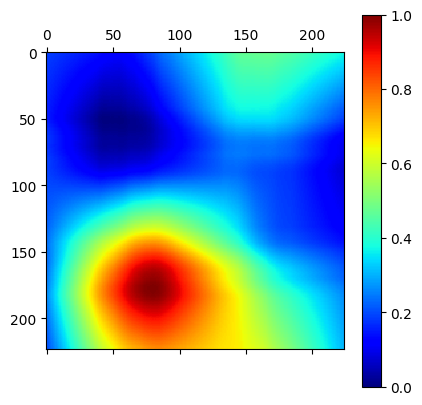

In [32]:
plt.matshow(heatmap_cbrise[0].cpu().detach().numpy(), cmap='jet')
plt.colorbar()

# pixel score

## activations

In [33]:
vc = VideoCallback(cmap='gray')
ps = PixelScore(model,model.input,activations,model.target,model.score)
ps_activations = getattr(ps,run_mode)(callbacks=[vc])
ps_auc_activations = ps.get_auc()
vc.save_video(f"results/ablation/output_activations_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4")

In [34]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'results/ablation/output_activations_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [35]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [36]:
# list(map(len,ps_activations)), ps_activations

## gradcam

In [37]:
vc = VideoCallback(cmap='gray')
ps = PixelScore(model,model.input,heatmap_gc,model.target,model.score)
ps_gc = getattr(ps,run_mode)(callbacks=[vc])
ps_auc_gc = ps.get_auc()
vc.save_video(f"results/ablation/output_gc_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4")

In [38]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'results/ablation/output_gc_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [39]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## occlusion

In [40]:
vc = VideoCallback(cmap='gray')
ps = PixelScore(model,model.input,heatmap_occ,model.target,model.score)
ps_occ = getattr(ps,run_mode)(callbacks=[vc])
ps_auc_occ = ps.get_auc()
vc.save_video(f"results/ablation/output_occ_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4")

In [41]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'results/ablation/output_occ_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_frames{len(vc.heatmaps)}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [42]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## rise

In [43]:
vc = VideoCallback(cmap='gray')
ps = PixelScore(model,model.input,heatmap_rise,model.target,model.score)
ps_rise = getattr(ps,run_mode)(callbacks=[vc])
ps_auc_rise = ps.get_auc()
vc.save_video(f"results/ablation/output_rise_{ps_mode}_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}_frames{len(vc.heatmaps)}.mp4")

In [44]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'results/ablation/output_rise_{ps_mode}_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}_frames{len(vc.heatmaps)}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [45]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## cbrise

In [46]:
vc = VideoCallback(cmap='gray')
ps = PixelScore(model,model.input,heatmap_cbrise,model.target,model.score)
ps_cbrise = getattr(ps,run_mode)(callbacks=[vc])
ps_auc_cbrise = ps.get_auc()
vc.save_video(f"results/ablation/output_cbrise_{ps_mode}_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}_frames{len(vc.heatmaps)}.mp4")

In [47]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'results/ablation/output_cbrise_{ps_mode}_len{len(imgs_url)}_model{model_name}_nmask{n_masks}_shape{initial_mask_shape}_frames{len(vc.heatmaps)}.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [48]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# abblation test

In [49]:
def set_figsize(fig, n_rows, n_columns, width_per_column=1.2, height_per_row=1.2):
    width = n_columns * width_per_column
    height = n_rows * height_per_row
    fig.set_size_inches(width, height)

In [50]:
def plot_score(axes, ps, i, j, auc, dilation=False):
    xy=np.array(ps[i])
    axes[i,j].plot(xy[:,0],xy[:,1])
    if not dilation:
        axes[i,j].axvline(xy[1,0],c='r')
        axes[i,j].invert_xaxis()
    else:
        axes[i,j].set_ylim(0, 1)
        axes[i,j].set_xlim(ps_threshold, 1)
    axes[i,j].tick_params(labelsize=6)
    # axes[i,4].set_aspect('equal', adjustable='box')
    slope=(xy[1,1]-xy[0,1])/(xy[1,0]-xy[0,0])
    axes[i,j].set_title("auc:{0:.2f}, $δ_s$:{1:.2f}".format(auc[i],slope), fontsize=8)

C:\Users\Cacho\AppData\Local\Temp\ipykernel_16260\552626305.py:14: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.75, wspace=0.5)


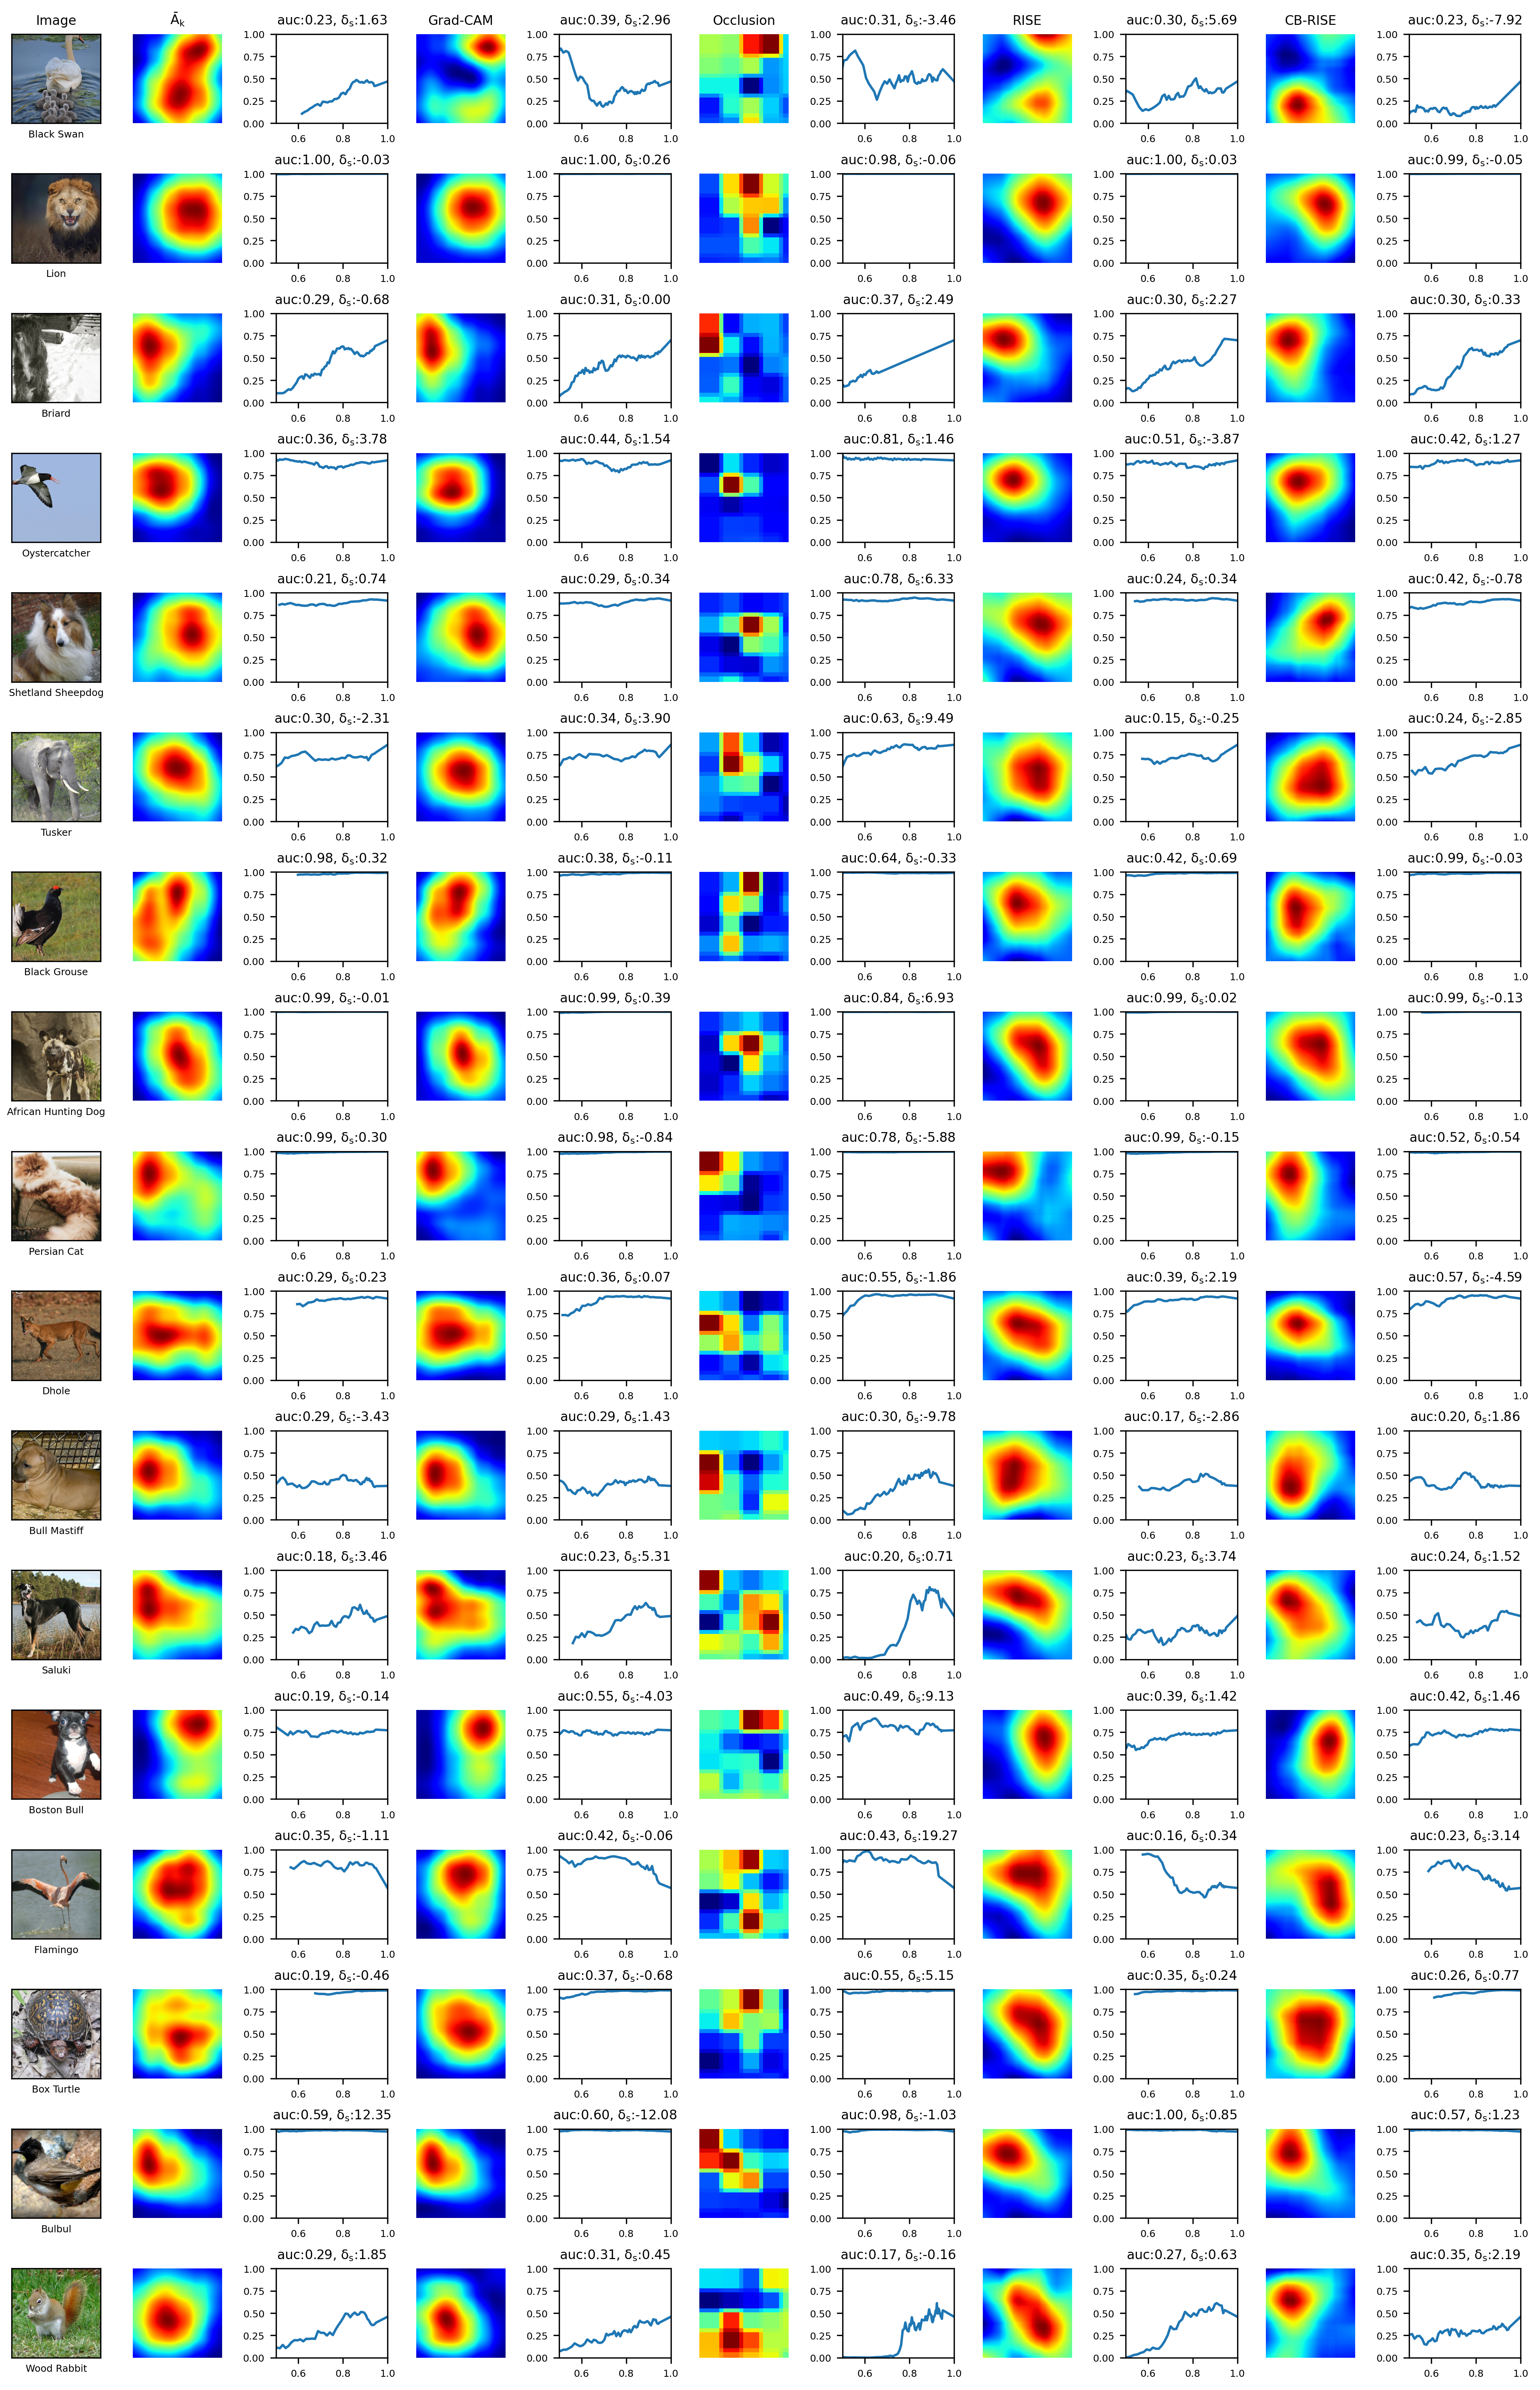

In [51]:
plt.rcParams.update({'mathtext.default':  'regular' })  #for subscript in set_title

attributions = [(activations, ps_activations, ps_auc_activations),
                (heatmap_gc, ps_gc, ps_auc_gc),
                (heatmap_occ, ps_occ, ps_auc_occ),
                (heatmap_rise, ps_rise, ps_auc_rise),
                (heatmap_cbrise, ps_cbrise, ps_auc_cbrise)]

cols=["$\\bar{A}_k$", "Grad-CAM", "Occlusion", "RISE", "CB-RISE"]

fig, axes = plt.subplots(inputs.shape[0],len(attributions)*2+1, constrained_layout=True)
set_figsize(fig,inputs.shape[0],len(attributions)*2+1) # fig.set_size_inches(8,20) #12,6
fig.set_dpi(300)
fig.subplots_adjust(hspace=0.75, wspace=0.5)
for i in range(inputs.shape[0]):
    axes[i,0].imshow(denormalized_inputs[i])
    # axes[i,0].axis('off')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_xlabel(f"{model_preds[i]['predicted_label'].replace('_', ' ').title()}", fontsize=6)
    for j,(attribution,ps,auc) in enumerate(attributions, start=0):
        idx=(j*2)+1
        im = axes[i,idx].imshow(attribution[i].detach().cpu().numpy(), cmap='jet')
        axes[i,idx].axis('off')
        axes[0,idx].set_title(cols[j], fontsize=8)#weight='bold')
        # minval, maxval = attribution[i].min().item(), attribution[i].max().item()
        # cbar = fig.colorbar(im, ax=axes[i,j], ticks=np.linspace(minval, maxval, 5), format=tkr.FormatStrFormatter('%.2f'), shrink=0.75)
        # cbar.ax.tick_params(labelsize=6)
        plot_score(axes, ps, i, idx+1, auc, dilation=(ps_mode == 'dilation'))
    # axes[i,4].imshow(denormalized_inputs[i].permute(1,2,0))
    # axes[i,4].imshow(heatmap_upsampled[i].detach().numpy(), cmap='jet', alpha=0.5)
axes[0,0].set_title("Image", fontsize=8)#weight='bold')

plt.savefig(f"results/ablation/ablation_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_nmask{n_masks}_shape{initial_mask_shape}.png", dpi=300)
plt.show()

In [52]:
df = pd.DataFrame({
    'ps_auc_activations': ps_auc_activations.numpy(),
    'ps_auc_gc': ps_auc_gc.numpy(),
    'ps_auc_occ': ps_auc_occ.numpy(),
    'ps_auc_rise': ps_auc_rise.numpy(),
    'ps_auc_cbrise': ps_auc_cbrise.numpy(),
})

df.to_csv(f"results/ablation/scores_{ps_mode}_len{len(imgs_url)}_model{model_name}_attr{attribution_name}_layer{layer_number}_nmask{n_masks}_shape{initial_mask_shape}.csv", index=False)

In [53]:
df.mean()

ps_auc_activations    0.454585
ps_auc_gc             0.486175
ps_auc_occ            0.577218
ps_auc_rise           0.462295
ps_auc_cbrise         0.467018
dtype: float32

# calc mean

In [54]:
import os
import pandas as pd
from pathlib import Path

directory = "results/ablation"

for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        print(file_name)
        df = pd.read_csv(Path(directory) / file_name)
        print(df.mean())

scores_dilation_len17_modelresnet18_attrlayer4_layer1_nmask2048_shape(4, 4).csv
ps_auc_activations    0.454585
ps_auc_gc             0.486175
ps_auc_occ            0.577218
ps_auc_rise           0.462295
ps_auc_cbrise         0.467019
dtype: float64
scores_dilation_len17_modelvgg16_attrfeatures_layer30_nmask2048_shape(4, 4).csv
ps_auc_activations    0.674171
ps_auc_gc             0.670583
ps_auc_occ            0.666275
ps_auc_rise           0.557336
ps_auc_cbrise         0.586935
dtype: float64
scores_erosion_len17_modelresnet18_attrlayer4_layer1_nmask2048_shape(4, 4).csv
ps_auc_activations    0.632872
ps_auc_gc             0.664206
ps_auc_occ            0.570779
ps_auc_rise           0.646453
ps_auc_cbrise         0.653912
dtype: float64
scores_erosion_len17_modelvgg16_attrfeatures_layer30_nmask2048_shape(4, 4).csv
ps_auc_activations    0.694335
ps_auc_gc             0.664539
ps_auc_occ            0.696151
ps_auc_rise           0.753361
ps_auc_cbrise         0.743734
dtype: float64


In [55]:
import os
import torch

directory = "results/ablation"
file_prefix = "metrics_cbrise_len17"
file_iterations = {}

for file_name in os.listdir(directory):
    if file_name.startswith(file_prefix):
        file_path = os.path.join(directory, file_name)
        data = torch.load(file_path)
        iterations_sum = sum(d["iterations"] for d in data)
        num_dicts = len(data)
        mean_iterations = iterations_sum / num_dicts
        file_iterations[file_name] = mean_iterations

for file_name, mean_iterations in file_iterations.items():
    print(f"{file_name}: {mean_iterations}")

metrics_cbrise_len17_modelresnet18_nmask2048_shape(4, 4).pt: 1566.1176470588234
metrics_cbrise_len17_modelvgg16_nmask2048_shape(4, 4).pt: 1615.0588235294117


C:\Users\Cacho\AppData\Local\Temp\ipykernel_16260\731300360.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)
